In [1]:
import pathlib

import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import daft
import arviz as az
import pymc as pm
import aesara.tensor as tt

In the examples in the Hierarchical Models 1 notebook, our models have assumed that all of the objects we observe are true members of the population we want to model (e.g., star cluster, or all of the RV systems we had were binary star systems). We very rarely have this luxury: We typically have a complex superposition of multiple structures, or at least two components corresponding to an object of interest and the "field" or "background" population of objects. Another similar context in which a one-component population model would not be sufficient is when there are outliers in a dataset. For these contexts, the models we wrote down and explored in Hierarchical Models 1 are too simple to be useful for many real-world applications.

One way of handling datasets that contain objects from different populations or outliers is to use a *mixture model*. Because of how many problems have this structure, I personally think that mixture models are one of the most important tools to know as a data-oriented astronomer. Let's first talk about the fundamentals of mixture models and then explore an example of using a mixture model to measure the distance to a star cluster using Gaia data. 

## Gaussian Mixture Models

In the models we have looked at so far, any parameter or variable is either drawn from a single distribution (e.g., a single normal distribution in many cases) or is deterministically related to another variable (e.g., distance and parallax). However, this does not have to be the case: the underlying density distribution of a random variable could instead be a more complex thing, such as a mixture of multiple component distributions that each have their own parameters. 

A common and important example used in many statistics and machine learning applications is the *Gaussian Mixture Model* (GMM), in which the probability density $p(x | \boldsymbol{\theta})$ of some variable $x$ given parameters $\boldsymbol{\theta}$ is modeled as a sum of Gaussians each with a weight $w$. For example, for $K$ Gaussian mixture components, the GMM density is:

$$
p(x | \boldsymbol{\mu}, \boldsymbol{\sigma}) = 
    \sum_k^K w_k \, \mathcal{N}(x | \mu_k, \sigma_k^2)
$$

where 

$$
\sum_k^K w_k = 1
$$

and $\boldsymbol{\mu} = (\mu_1, \mu_2, ..., \mu_k)$, and again $\mathcal{N}(x \,|\, \mu, \sigma^2)$ represents a univariate normal distribution with mean $\mu$ and variance $\sigma^2$ (i.e. $\sigma$ is the standard deviation):

$$
\mathcal{N}(x \,|\, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi} \, \sigma} \, 
    \exp\left[-\frac{(x - \mu)^2}{2\,\sigma^2} \right]
$$

With the constraint on the sum of the weights, this GMM density still integrates to 1 and is therefore a valid probability density function, but now can have complex possibly multi-modal structure.

### Example: Fitting a line to data with Gaussian outliers

As a demonstration of using a Gaussian Mixture Model to handle outliers, we will return to the example case of fitting a straight line to data, but now we will assume that the data we have been given include outliers.

Let's first generate simulated data to work with:

In [2]:
rng = np.random.default_rng(seed=42)

N = 32
true_p = {"m": 3.17, "b": -11.9}
true_x = np.sort(rng.uniform(0, 10, N))
true_y = true_p["m"] * true_x + true_p["b"]

N_out = 8
out_idx = rng.choice(N, size=N_out)
true_y[out_idx] = rng.normal(0, 15, size=N_out)
y_err = rng.uniform(0.5, 3, N)

gmm_data = {"x": true_x, "y": rng.normal(true_y, y_err), "y_err": y_err}

Because this is simulated data, we know which points are outliers — let's plot the data and use a different marker for the outliers to see:

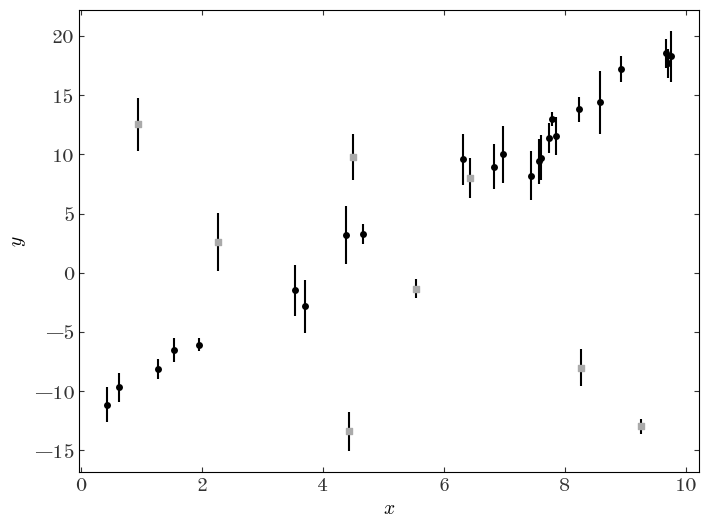

In [3]:
plt.figure(figsize=(8, 6))
plt.errorbar(gmm_data["x"], gmm_data["y"], gmm_data["y_err"], marker="o", ls="none")

plt.scatter(
    gmm_data["x"][out_idx],
    gmm_data["y"][out_idx],
    marker="s",
    facecolor="#aaaaaa",
    zorder=10,
)

plt.xlabel("$x$")
plt.ylabel("$y$");

As a demonstration of the impact of outliers or populations of objects that belong to a different class in the context of model fitting, let's do a linear least-squares regression to the data assuming now that we don't know a priori which points are outliers vs. not:

In [4]:
X = np.vander(gmm_data["x"], N=2)
Cinv = np.diag(1 / gmm_data["y_err"] ** 2)
leastsq_m, leastsq_b = np.linalg.solve(X.T @ Cinv @ X, X.T @ Cinv @ gmm_data["y"])

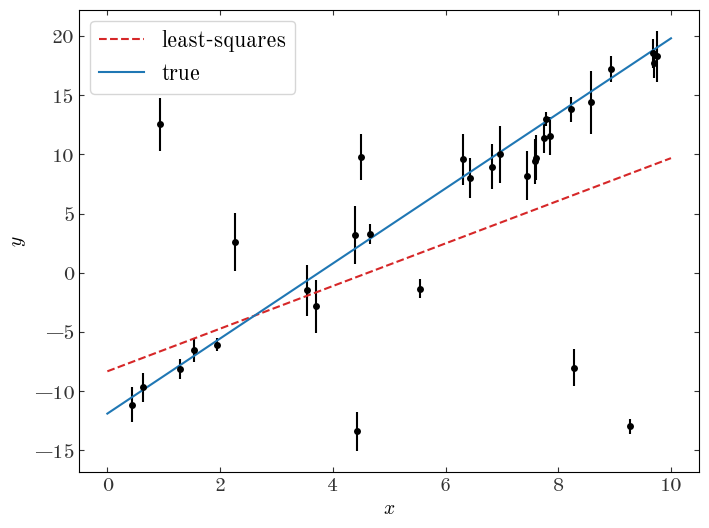

In [5]:
plt.figure(figsize=(8, 6))
plt.errorbar(gmm_data["x"], gmm_data["y"], gmm_data["y_err"], marker="o", ls="none")

xgrid = np.linspace(0, 10, 128)
plt.plot(
    xgrid,
    leastsq_m * xgrid + leastsq_b,
    marker="",
    color="tab:red",
    label="least-squares",
    linestyle="--",
)
plt.plot(
    xgrid, true_p["m"] * xgrid + true_p["b"], marker="", color="tab:blue", label="true"
)
plt.legend(fontsize=16)

plt.xlabel("$x$")
plt.ylabel("$y$");

The outliers have clearly biased our fit and led us to infer parameters for this linear model that are not consistent with the truth. Let's now construct a model to deal with these outlier data points. 

As mentioned above, we will use a *Gaussian Mixture Model* as a way of modeling the true density of objects, with one mixture component to represent the objects that follow the linear relation as we expect, and a second mixture component to represent the outliers. When constructing an outlier model, it sometimes helps to know about why these objects are outliers and to explicitly write down a generative model for the process that leads to these other data. This adds a little additional complexity to a model, but allows us to be more justified in our choice of outlier model and can lead to more precise inferences of the parameters you actually want to learn. Plus, as we saw, if you use MCMC methods to generate posterior samples over all of the parameters (inlier and outlier model components), you can use these samples to marginalize over the outlier model and obtain robust estimates of the inlier model. 

However, sometimes you don't know about the outliers, or you don't care and just need to get something working as a prototype. In these cases, using a broad Gaussian or other wide distribution to capture the outliers is often a good practical choice. That's the assumption we will work with her for our simulated data: We will assume the inlier data are generated from a straight line with Gaussian uncertainties, and the outlier distribution is a Gaussian centered on zero with an unknown variance. With mixture weights $\boldsymbol{w}=(w_1, w_2)$ such that $w_1 + w_2 = 1$, data $y$ and uncertainties $\sigma_y$, and outlier component standard deviation $\sigma_{\rm out}$, this model looks like:

$$
\begin{align}
\hat{y} &= m \, x + b\\
p(y \,|\, \hat{y}) &= \mathcal{N}(y \,|\, \hat{y}, \sigma_y^2) \\
p(\hat{y} \,|\, m, b) &= 
    w_1 \, \delta\left[\hat{y} - (m\,x + b)\right] +
    w_2 \, \mathcal{N}(\hat{y} \,|\, 0, \sigma_{\rm out}^2)
\end{align}
$$

where $\delta\left[\cdot\right]$ is the Dirac delta function.

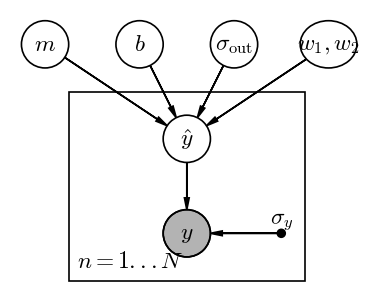

In [6]:
pgm = daft.PGM(dpi=120)

pgm.add_node("y", r"$y$", 0, 0, observed=True)
pgm.add_node("yhat", r"$\hat{y}$", 0, 1)
pgm.add_node("m", r"$m$", -1.5, 2)
pgm.add_node("b", r"$b$", -0.5, 2)
pgm.add_node("sigmao", r"$\sigma_{\rm out}$", 0.5, 2)
pgm.add_node("w", r"$w_1, w_2$", 1.5, 2, aspect=1.2)
pgm.add_node("sigmay", r"$\sigma_y$", 1, 0, fixed=True)

pgm.add_edge("yhat", "y")
pgm.add_edge("m", "yhat")
pgm.add_edge("b", "yhat")
pgm.add_edge("sigmao", "yhat")
pgm.add_edge("w", "yhat")
pgm.add_edge("sigmay", "y")

pgm.add_plate([-1.25, -0.5, 2.5, 2], label=r"$n = 1...N$", position="bottom left")

pgm.render();

At face value, this looks like the stellar distance model we explored in the previous notebook: We have some population-level parameters ($m, b, \sigma_{\rm out}, \boldsymbol{w}$), and many object-level parameters (the $\hat{y}$'s). Given the PGM above, our joint probability for the parameters can be factorized as:

$$
p(m, b, \sigma_{\rm out}, \boldsymbol{w}, \hat{\boldsymbol{y}}, \boldsymbol{y}) =
    p(\boldsymbol{y} \,| \, \hat{\boldsymbol{y}}) \, 
    p(\hat{\boldsymbol{y}} \,|\, m, b, \sigma_{\rm out}, \boldsymbol{w}) \,
    p(m) \, p(b) \, p(\sigma_{\rm out}) \, p(\boldsymbol{w})
$$

However, unlike the parallax/distance example, here because of the forms of the mixture model components above, it turns out that we can analytically marginalize out the per-object "true" $y$ parameters $\hat{y}$. The relevant integrals either contain a convolution of a Gaussian and a delta function, or two Gaussians, both of which have closed-form solutions:

$$
\begin{align}
p(m, b, \sigma_{\rm out}, w, \boldsymbol{y}) &= 
    \int \textrm{d} \hat{\boldsymbol{y}} \, 
        p(m, b, \sigma_{\rm out}, \boldsymbol{w}, \hat{\boldsymbol{y}}, \boldsymbol{y}) \\
    &= p(m) \, p(b) \, p(\sigma_{\rm out}) \, p(\boldsymbol{w}) \, 
        \int \textrm{d} \hat{\boldsymbol{y}} \,
            p(\boldsymbol{y} \,| \, \hat{\boldsymbol{y}}) \, 
            p(\hat{\boldsymbol{y}} \,|\, m, b, \sigma_{\rm out}, \boldsymbol{w}) \\
\int \textrm{d} \hat{y} \, 
    p(y \,| \, \hat{y}) \, 
    p(\hat{y} \,|\, m, b, \sigma_{\rm out}, \boldsymbol{w})
        &= w_1 \, \int \textrm{d} \hat{y} \,
            \mathcal{N}(y \,|\, \hat{y}, \sigma_y^2) \, \delta\left[\hat{y} - (m\,x + b)\right]
            + w_2 \, \int \textrm{d} \hat{y} \,
            \mathcal{N}(y \,|\, \hat{y}, \sigma_y^2) \, \mathcal{N}(\hat{y} \,|\, 0, \sigma_{\rm out}^2)\\
        &= w_1 \, \mathcal{N}(y \,|\, m\,x + b, \sigma_y^2) + 
            w_2 \, \mathcal{N}(y \,|\, 0, \sigma_y^2 + \sigma_{\rm out}^2)
\end{align}
$$

Let's implement this model with pymc:

In [7]:
with pm.Model() as model_line:
    # We will be lazy and use fairly simple prior pdfs for the slope and intercept of
    # the linear model:
    m = pm.Uniform("m", 0, 10, initval=3.0)
    b = pm.Normal("b", 0, 25, initval=-13.0)

    # For sigma_out, we will sample in log-sigma and use a linear prior on this
    # transformed parameter, which is equivalent to a prior p(s) ~ 1/s:
    ln_s_out = pm.Uniform("ln_s_out", -3, 4, initval=np.log(10.0))
    s2_out = pm.Deterministic("s_out", pm.math.exp(2 * ln_s_out))

    # The mixture weight w can be thought of as two parameters that represent the
    # weights of each component in the mixture, but they must sum to one. Variables of
    # this form can be represented with a Dirichlet distribution:
    w = pm.Dirichlet("w", a=np.array([1, 1]))

    # For mixtures of Gaussian (Normal) distributions, pymc has a special helper class:
    pm.NormalMixture(
        "y",
        w=w,
        mu=pm.math.stack([m * gmm_data["x"] + b, tt.zeros(len(gmm_data["x"]))]).T,
        sigma=pm.math.sqrt(
            pm.math.stack([gmm_data["y_err"] ** 2, gmm_data["y_err"] ** 2 + s2_out]).T
        ),
        observed=gmm_data["y"],
    )

    # With all model components defined, we can now generate posterior samples:
    samples_line = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [m, b, ln_s_out, w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


Let's look at statistics of the parameter chains:

In [8]:
az.summary(samples_line)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,-11.979,0.449,-12.810,-11.123,0.012,0.009,1356.0,1180.0,1.0
m,3.137,0.074,3.001,3.274,0.002,0.001,1378.0,1117.0,1.0
ln_s_out,2.324,0.270,1.841,2.844,0.007,0.005,1587.0,876.0,1.0
w[0],0.734,0.085,0.575,0.880,0.002,0.001,1762.0,1222.0,1.0
w[1],0.266,0.085,0.120,0.425,0.002,0.002,1762.0,1222.0,1.0
s_out,122.239,81.960,29.259,258.722,2.694,2.069,1587.0,876.0,1.0


Based on the convergence statistic (`r_hat` close to 1) and the ESS parameters (in the thousands), it looks like the sampling succeeded. Let's make a corner plot:

/opt/hostedtoolcache/Python/3.10.7/x64/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:94: UserWarning: Argument reference_values does not include reference value for: w 0, w 1, s_out
  warnings.warn(


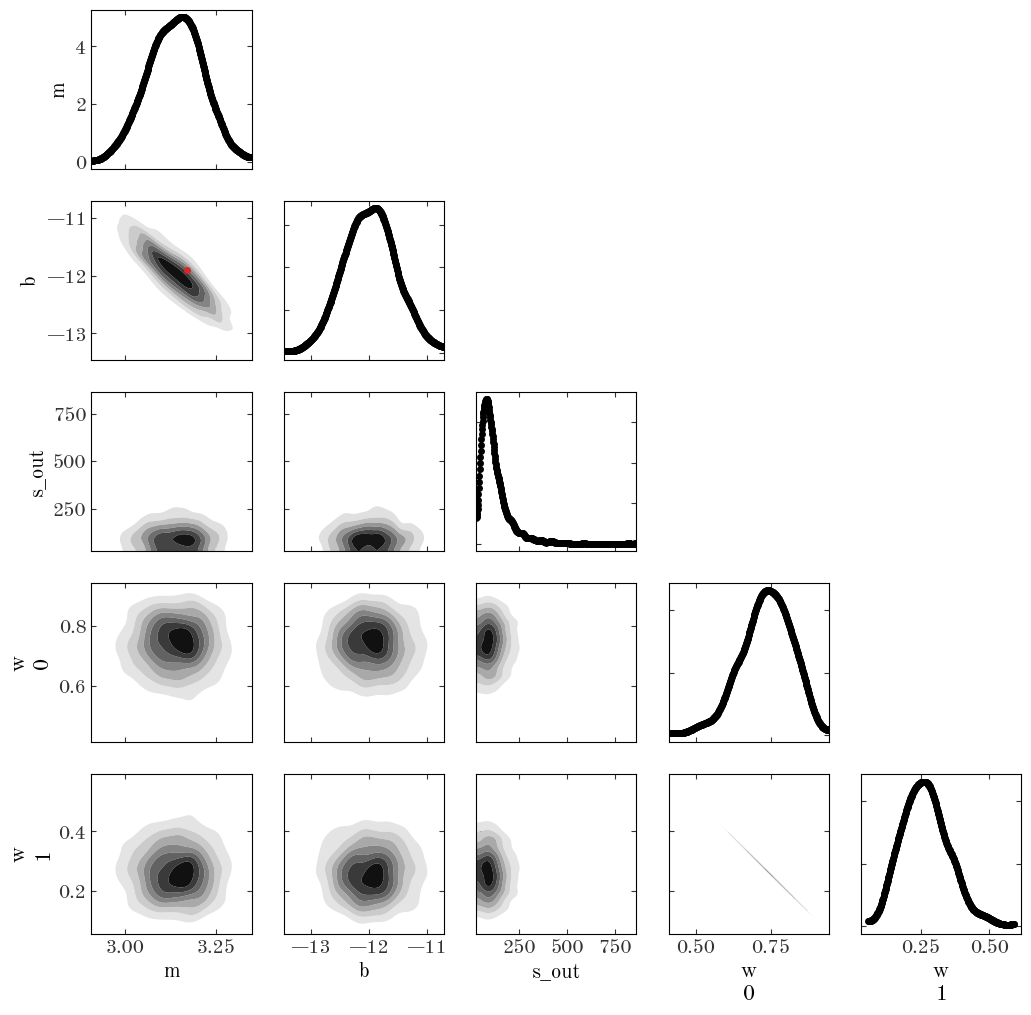

In [9]:
az.plot_pair(
    samples_line,
    var_names=["m", "b", "s_out", "w"],
    marginals=True,
    kind="kde",
    kde_kwargs=dict(contourf_kwargs=dict(cmap="Greys"), contour_kwargs=dict(alpha=0.0)),
    figsize=(12, 12),
    reference_values=true_p,
    reference_values_kwargs=dict(
        color="tab:red", markersize=5, label="true values", linestyle="none"
    ),
);

We can also use the posterior samples to plot a credible region for our straight line model in the space of our data. First, we will extract a subset of the samples to use:

In [10]:
samples_line_subset = az.extract_dataset(samples_line, num_samples=1024, rng=rng)

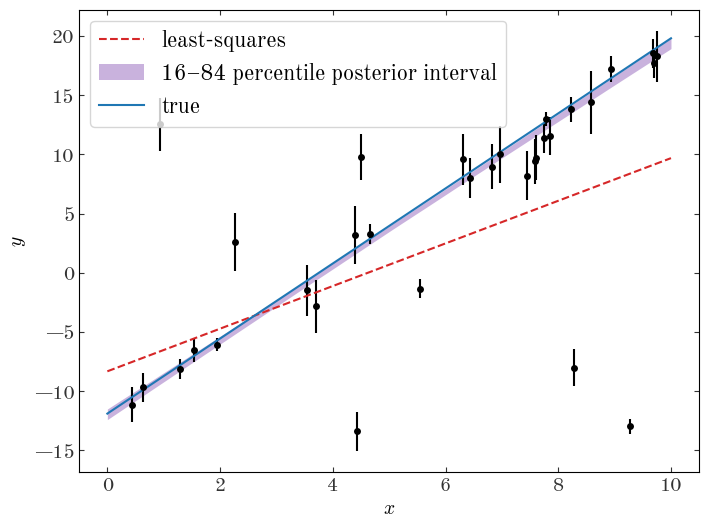

In [11]:
plt.figure(figsize=(8, 6))
plt.errorbar(gmm_data["x"], gmm_data["y"], gmm_data["y_err"], marker="o", ls="none")

xgrid = np.linspace(0, 10, 128)
plt.plot(
    xgrid,
    leastsq_m * xgrid + leastsq_b,
    marker="",
    color="tab:red",
    label="least-squares",
    linestyle="--",
)

model_tmp = (
    samples_line_subset.m.values[None] * xgrid[:, None]
    + samples_line_subset.b.values[None]
)
plt.fill_between(
    xgrid,
    *np.percentile(model_tmp, [16, 84], axis=1),
    color="tab:purple",
    alpha=0.5,
    linewidth=0,
    label="16–84 percentile posterior interval"
)

plt.plot(
    xgrid, true_p["m"] * xgrid + true_p["b"], marker="", color="tab:blue", label="true"
)
plt.legend(fontsize=16)

plt.xlabel("$x$")
plt.ylabel("$y$");

Already our inference looks much more robust, and we recover parameters for the line model that are much more consistent with the truth. Awesome!

One other thing we can do with a model like this is to compute membership probabilities for each object in our sample — that is, we can compute estimates of the marginal posterior probability that a given object belongs in each of the classes in our model (here either the straight line component or the outlier population). 

If we define $q$ to be a discrete class label such that $q=0$ means a star belongs to the straight line mixture component, and $q=1$ means that a star is an outlier, we would like to get an estimate of $p(q=0 \,|\, \boldsymbol{y})$, i.e. the marginal posterior probability of being a straight line member, for each object. Defining $\boldsymbol{\theta} = (m, b, \sigma_{\rm out}, \boldsymbol{w})$ for brevity, the marginal posterior probability is equal to:

$$
p(q=0 \,|\, \boldsymbol{y}) = \int \textrm{d}\boldsymbol{\theta} \, 
    p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}) \,
    p(\boldsymbol{\theta} \,|\, \boldsymbol{y})
$$

On the right hand side, $p(\boldsymbol{\theta} \,|\, \boldsymbol{y})$ is the posterior pdf we generated samples from above — using the trick of Monte Carlo integration, we can therefore turn the integral in the expression above into a sum over posterior samples:

$$
p(q=0 \,|\, \boldsymbol{y}) \approx \sum_j p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}_j)
$$

where $\boldsymbol{\theta}_j$ is a sample from the posterior pdf (i.e. from the parameter chains generated above). But what is the pdf we need to evaluate inside the sum? Let's start by looking at and factorizing the joint probability $p(q=0, \boldsymbol{y} \,|\, \boldsymbol{\theta})$:

$$
\begin{align}
p(q=0, \boldsymbol{y} \,|\, \boldsymbol{\theta}) &= 
    p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}) \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}) \\
    &= p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=0) \, p(q=0)
\end{align}
$$

If we set these equal to another, we can see that:

$$
p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}) = 
    \frac{p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=0) \, p(q=0)}{p(\boldsymbol{y} \,|\, \boldsymbol{\theta})}
$$

Now,

$$
p(q=0) = w_1\\
p(q=1) = w_2\\
p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=0) = \mathcal{N}(y \,|\, m\,x + b, \sigma_y^2)\\
p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=1) = \mathcal{N}(y \,|\, 0, \sigma_y^2 + \sigma_{\rm out}^2)
$$

and 

$$
\begin{align}
p(\boldsymbol{y} \,|\, \boldsymbol{\theta}) &= 
    p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=0) \, p(q=0) +
    p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=1) \, p(q=1) \\
    &= w_1 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=0) +
    w_2 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=1)
\end{align}
$$

Putting all of this together, we get:

$$
p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}) = 
    \frac{w_1 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=0) \, }{w_1 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=0) + w_2 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}, q=1)}
$$

and therefore 

$$
p(q=0 \,|\, \boldsymbol{y}) \approx \frac{w_1 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}_j, q=0) \, }{w_1 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}_j, q=0) + w_2 \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}_j, q=1)}
$$

Phew! That was a lot of math, but the end result is a fairly simple expression that we can compute using the mixture model component distributions evaluated at the parameter values in the MCMC chains. Unfortunately, the `NormalMixture` implementation does not give us access to the individual mixture component probabilities, so we have to re-implement the model using the more general `Mixture` class, and keep track of the component probabilities as pymc `Deterministic` variables:

In [12]:
with pm.Model() as model_line2:
    # Same as above:
    m = pm.Uniform("m", 0, 10, initval=3.0)
    b = pm.Normal("b", 0, 25, initval=-13.0)

    # Same as above:
    ln_s_out = pm.Uniform("ln_s_out", -3, 4, initval=np.log(10.0))
    s2_out = pm.Deterministic("s_out", pm.math.exp(2 * ln_s_out))

    # Same as above:
    w = pm.Dirichlet("w", a=np.array([1, 1]))

    # For mixtures of Gaussian (Normal) distributions, pymc has a special helper class:
    dist1 = pm.Normal.dist(m * gmm_data["x"] + b, gmm_data["y_err"])
    dist2 = pm.Normal.dist(0.0, pm.math.sqrt(gmm_data["y_err"] ** 2 + s2_out))
    pm.Deterministic("logp1", pm.logp(dist1, gmm_data["y"]))
    pm.Deterministic("logp2", pm.logp(dist2, gmm_data["y"]))

    pm.Mixture("y", w=w, comp_dists=[dist1, dist2], observed=gmm_data["y"])

    # With all model components defined, we can now generate posterior samples:
    samples_line2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [m, b, ln_s_out, w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


Over the parameters $m, b, \sigma_{\rm out}, \boldsymbol{w}$, this model should be equivalent to the previous implementation. However, this model has two additional variables computed at each location in the chains: `logp1` and `logp2`, which contain the log-probability values of the two mixture components at each location in the chains. Let's extract these values:

In [13]:
line2_logps = az.extract_dataset(samples_line2, var_names=["logp1", "logp2"])

To implement the sum defined above we need the un-logged values of the probabilities, so a more robust way of computing these sums is to use [`logsumexp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html):

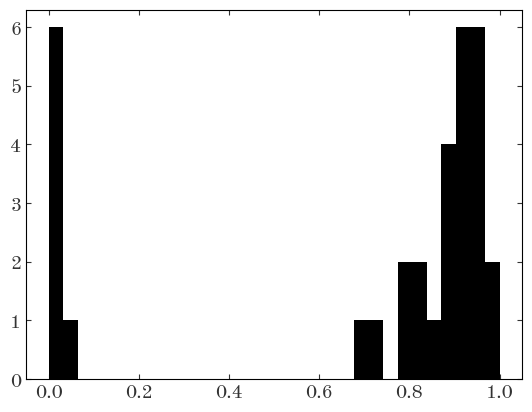

In [14]:
from scipy.special import logsumexp

denom = np.logaddexp(line2_logps.logp1.values, line2_logps.logp2.values)
membership_probs = (
    np.exp(logsumexp(line2_logps.logp1.values - denom, axis=1))
    / line2_logps.logp1.values.shape[1]
)

plt.hist(membership_probs, bins=np.linspace(0, 1, 32));

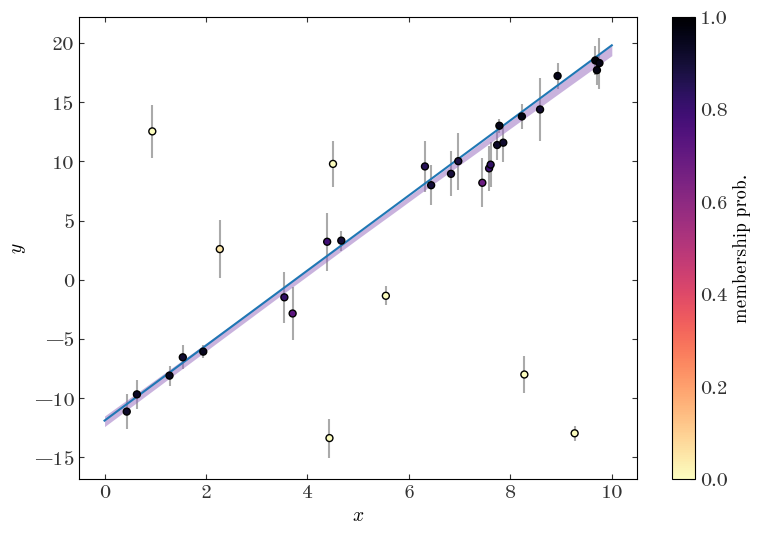

In [15]:
plt.figure(figsize=(9, 6))
plt.errorbar(
    gmm_data["x"],
    gmm_data["y"],
    gmm_data["y_err"],
    marker="",
    ls="none",
    ecolor="#aaaaaa",
    zorder=1,
)
cs = plt.scatter(
    gmm_data["x"],
    gmm_data["y"],
    c=membership_probs,
    zorder=10,
    cmap="magma_r",
    vmin=0,
    vmax=1,
    linewidth=1,
    edgecolor="k",
)
cb = plt.colorbar(cs)
cb.set_label("membership prob.")

model_tmp = (
    samples_line_subset.m.values[None] * xgrid[:, None]
    + samples_line_subset.b.values[None]
)
plt.fill_between(
    xgrid,
    *np.percentile(model_tmp, [16, 84], axis=1),
    color="tab:purple",
    alpha=0.5,
    linewidth=0,
    label="16–84 percentile posterior interval"
)

plt.plot(
    xgrid, true_p["m"] * xgrid + true_p["b"], marker="", color="tab:blue", label="true"
)

plt.xlabel("$x$")
plt.ylabel("$y$");

## Other Resources

Other good resources on this topic are:
- [Dan F-M's Mixture Models tutorial](https://dfm.io/posts/mixture-models/)
- Dan's similar [outlier model implemented with numpyro](https://dfm.io/posts/intro-to-numpyro/)

## Mixture Models in General

The above example with Gaussian Mixture Models introduced us to a lot of the key concepts of working with mixture models, but it's important to note that mixture models do not only have to contain Gaussian mixture component distributions. In the problem below, you will implement and use a mixture model that contains different forms of component distributions.

### Problem: Choose your own adventure in star cluster membership modeling

You have a few different options for this problem, but all involve inferring the properties of a star cluster — NGC 6819, which was discovered by [Caroline Herschel](https://en.wikipedia.org/wiki/Caroline_Herschel) — given real astrometric measurements of stars in the sky region around the cluster from the Gaia mission's Data Release 3 (DR3). Here is an image of NGC 6819 from the Digitized Sky Survey (DSS):

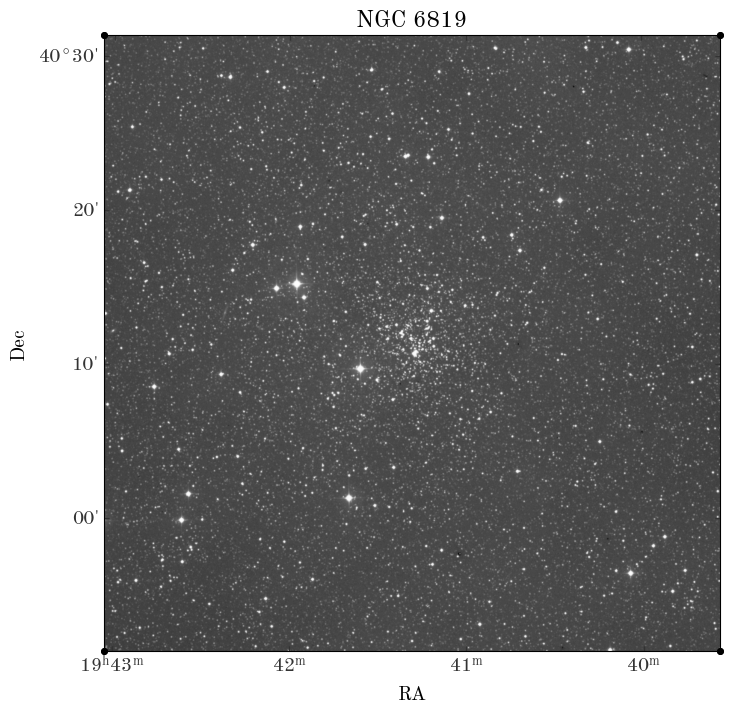

In [16]:
from astropy.io import fits
from astropy.wcs import WCS

hdul = fits.open("NGC6819-DSS-r.fits")
wcs = WCS(hdul[0].header)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=wcs))
ax.imshow(hdul[0].data, origin="lower", cmap="Greys_r")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.set_title("NGC 6819");

I already downloaded Gaia data for a region around the known location of the cluster (see the `Get-data.ipynb` notebook if you want to know how I queried and downloaded this data), so let's start by loading the data using `pyia`:

In [17]:
from pyia import GaiaData

g = GaiaData("NGC6819-gaiadr3.fits.gz")

In case it is useful, we can create an Astropy `SkyCoord` object with:

In [18]:
c = g.get_skycoord(distance=False)

And for the know position of the center of the cluster:

In [19]:
c_cluster = coord.SkyCoord.from_name("NGC 6819")

#### Options:

Your options, listed in increasing complexity and difficulty, are:
1. Implement a 1D mixture model to infer which stars in this field are plausible members of NGC 6819 using only the proper motion in RA (`g.pmra` and `g.pmra_error` for the proper motion values and uncertainties). Also measure the mean proper motion of the cluster. You can represent the cluster component as a Gaussian, but the field population is clearly not Gaussian — use a different distribution to capture the field. *Hint: you could use a GMM for the field, and mix that with another Gaussian component to represent the cluster.* This requires a slight extension of the model used above. (**good place to start**)


2. Implement a 1D mixture model using only the parallaxes to infer the mean distance of NGC 6819 (`g.parallax` and `g.parallax_error` for the parallax values and uncertainties). You can represent the cluster component as a Gaussian, but the field population is clearly not Gaussian — use a different distribution to capture the field population. *Hint: you could try using a Beta distribution, or you could implement a custom distribution to implement an exponentially decreasing space density prior as defined and demonstrated in [Bailer-Jones et al. 2015](https://ui.adsabs.harvard.edu/abs/2015PASP..127..994B/abstract). If you go with the latter, you will need to use the `pymc.DensityDist()` class — ask Adrian for some tips if interested!* This requires mashing together the hierarchical model we implemented in notebook 1 with the mixture models above. (**intermediate difficulty**)


3. Implement a 3D mixture model using both proper motion components to infer the mean proper motion vector of NGC 6819. You can represent the cluster component as a 2D isotropic Gaussian, but the field population is clearly not Gaussian or isotropic — use a different 2D distribution to capture the field population. *Hint: you could try using a mixture of Gaussians. Note also that the proper motions have covariances, reported via the `pmra_pmdec_corr` column! — if you are interested in implementing this and get stuck, ask Adrian for some other tips to get started.* (**hard**)


4. Implement a membership model to use sky position, parallax, and proper motions together to infer the 3D Cartesian position and velocity of the cluster. (**very hard — a publishable unit!**)

In whatever path you take, you may find it useful to have a subsample of stars that contains a high (fractional) number of cluster members, and a comparison subsample that is mostly field stars. You can make boolean masks based on on sky separation from the cluster center with, e.g.:

In [20]:
cl_sky_mask = c.separation(c_cluster) < 5 * u.arcmin
no_cl_sky_mask = c.separation(c_cluster) > 15 * u.arcmin

cl_sky_mask.sum(), no_cl_sky_mask.sum()

(3328, 13664)